## Run a single example of the calibration for a certain set of parameters

In [1]:
include("ms_calibration.jl")

detuning_khz = 10
pi_time_blue_μs = 5
pi_time_red_μs = 7
ac_stark_shift_hz = 35
θ = HamiltonianParameters([detuning_khz, pi_time_blue_μs, pi_time_red_μs, ac_stark_shift_hz])

HamiltonianParameters(10.0, 5.0, 7.0, 35.0)

In [2]:
# demonstrate that we have achieve >99.99% fidelity with ideal parameters
@time ms_fidelity(θ, θ)

 33.611537 seconds (81.49 M allocations: 4.164 GiB, 4.24% gc time)


0.9999678828839386

In [3]:
include("ms_calibration.jl")
import PyPlot
const plt = PyPlot;

function rand_coeff()
    # returns a uniform random float in [0.9, 1.1]
    return 0.9 + (rand() * 0.2)
end

param_count = length(fieldnames(HamiltonianParameters))
initial_guess = HamiltonianParameters([as_vector(θ)[i] * rand_coeff() for i in 1:param_count])

N = 50
tspan_ideal = 0:0.1:200
tspan_experiment = 0:20:200

@time res = ms_calibration(θ, initial_guess, N, tspan_ideal, tspan_experiment)

ideal_fit_params = as_vector(res["ideal_fit_params"])
learned_fit_params = as_vector(res["learned_fit_params"])
error = [ideal_fit_params[i] - learned_fit_params[i] for i in 1:param_count]
relative_error = [error[i] / ideal_fit_params[i] for i in 1:param_count]

  5.142426 seconds (45.05 M allocations: 1.447 GiB, 6.55% gc time)


4-element Array{Float64,1}:
  0.0001094953749158023
 -0.00030256225102540666
 -0.006022574753339782
  0.011795193630814133

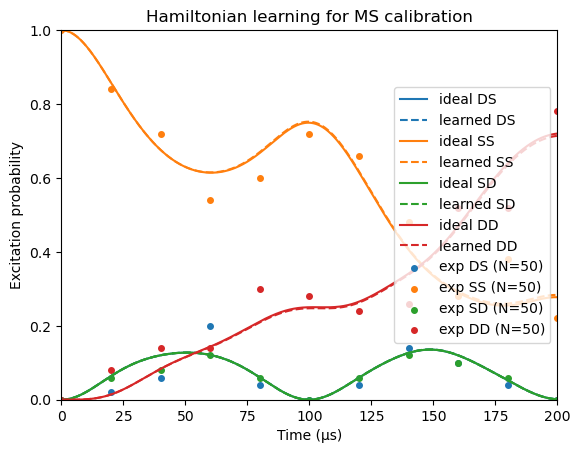

ideal fit parameters [10.0, 5.0, 7.0, 35.0]
learned fit parameters [9.998905046250842, 5.001512811255127, 7.0421580232733785, 34.587168222921505]
fit parameters relative error=[0.0001094953749158023, -0.00030256225102540666, -0.006022574753339782, 0.011795193630814133]


In [4]:
ideal = res["ideal_curve"]
learned = res["learned_curve"]
experimental = res["experimental_data"]

plt.figure()
for state in keys(experimental[1])
    plt.plot(tspan_ideal, getindex.(ideal, state), "-", label="ideal $state")
    plt.plot(tspan_ideal, getindex.(learned, state), "--", label="learned $state", color=plt.gca().lines[end].get_color())
    plt.scatter(tspan_experiment, getindex.(experimental, state), label="exp $state (N=$(N))", s=16, color=plt.gca().lines[end].get_color())
end

println("ideal fit parameters $(ideal_fit_params)")
println("learned fit parameters $(learned_fit_params)")
println("fit parameters relative error=$(relative_error)")

plt.title("Hamiltonian learning for MS calibration")
plt.xlim(tspan_ideal[1], tspan_ideal[end])
plt.ylim(0, 1)
plt.xlabel("Time (μs)")
plt.ylabel("Excitation probability")
plt.legend(loc="center right");

## Test the average error of the technique as a function of N

In [5]:
include("ms_calibration.jl")

n_repetitions = 20
n_shots_list = [5, 10, 25, 50, 100, 250, 500, 1000]

relative_error_results = Dict()
fidelities = Dict()
for n_shots in n_shots_list 
    print("Running for n_shots=$(n_shots)")
    relative_error_results[n_shots] = []
    fidelities[n_shots] = []
    for i = 1:n_repetitions
        print(".")
        
        initial_guess = HamiltonianParameters([as_vector(θ)[i] * rand_coeff() for i in 1:param_count])        
        tspan_ideal = 0:0.1:200
        tspan_experiment = 20:20:200
        res = ms_calibration(θ, initial_guess, n_shots, tspan_ideal, tspan_experiment)

        ideal_fit_params = as_vector(res["ideal_fit_params"])
        learned_fit_params = as_vector(res["learned_fit_params"])
        error = [ideal_fit_params[i] - learned_fit_params[i] for i in 1:param_count]
        relative_error = [error[i] / ideal_fit_params[i] for i in 1:param_count]
        push!(relative_error_results[n_shots], relative_error)
        
        # calculate the resulting error in MS-gate fidelity
        fidelity = ms_fidelity(θ, res["learned_fit_params"])
        push!(fidelities[n_shots], fidelity)
    end
    println(" complete!")
end

Running for n_shots=5.................... complete!
Running for n_shots=10.................... complete!
Running for n_shots=25.................... complete!
Running for n_shots=50.................... complete!
Running for n_shots=100.................... complete!
Running for n_shots=250.................... complete!
Running for n_shots=500.................... complete!
Running for n_shots=1000.................... complete!


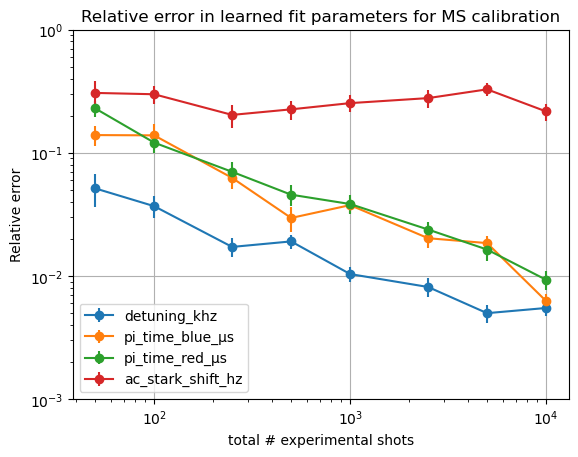

In [6]:
import PyPlot
const plt = PyPlot;
import Statistics

total_n_shots = [n_shots * length(tspan_experiment) for n_shots in n_shots_list]

plt.figure()

for (index, label) in enumerate(fieldnames(HamiltonianParameters))
    means = []
    stderrs = []
    for n_shots in n_shots_list
        relative_errors = [abs(errors[index]) for errors in relative_error_results[n_shots]]
        push!(means, mean(relative_errors))
        push!(stderrs, Statistics.std(relative_errors) / sqrt(length(relative_errors)))
    end
    plt.errorbar(x=total_n_shots, y=means, yerr=stderrs, linestyle="-", marker="o", label=label)
end

plt.title("Relative error in learned fit parameters for MS calibration")
plt.ylim(1e-3, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("total # experimental shots")
plt.ylabel("Relative error")
plt.legend()
plt.grid();

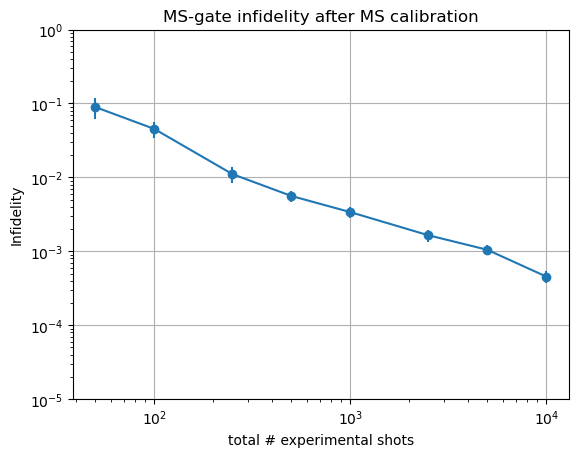

In [7]:
import PyPlot
const plt = PyPlot;
using Statistics

fidelity_means = []
fidelity_stderrs = []
for n_shots in n_shots_list
    push!(fidelity_means, mean(fidelities[n_shots]))
    push!(fidelity_stderrs, Statistics.std(fidelities[n_shots]) / sqrt(length(fidelities[n_shots])))
end

plt.figure()
plt.errorbar(x=total_n_shots, y=1 .- fidelity_means, yerr=fidelity_stderrs, linestyle="-", marker="o")

plt.title("MS-gate infidelity after MS calibration")
plt.ylim(1e-5, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("total # experimental shots")
plt.ylabel("Infidelity")
plt.grid();

## Print the raw result data

In [8]:
print(relative_error_results)

Dict{Any,Any}(25 => Any[[-0.004634622677744638, -0.016053177828985455, -0.025552564380018645, -0.5139812262060474], [0.03411319829178154, -0.026118575393400966, -0.03137031833535607, -0.029154372058704324], [-0.007228547488048065, 0.05075341936482687, 0.03509970031325541, 0.024834625620496605], [-0.03717934139066568, 0.03852242064854252, 0.06800420885226201, 0.026397997302836373], [-0.015199282400011782, -0.20951786960175411, 0.243096713888114, 0.03563601910663761], [-0.028873688110974172, -0.06997143298421396, 0.08348793986334245, 0.23117490254596892], [-0.003978053026342287, -0.15903572741637007, 0.09346794654711069, -0.08995586564488767], [-0.017717633760698525, -0.06221859216120222, 0.12650462094499076, -0.5541267674006732], [0.0038259388044755483, -0.009676573470660976, -0.019573943467932255, -0.11851215151937668], [-0.017449900398844774, 0.031416114336329494, 0.06409716338917068, -0.4427962423021372], [0.0018103025704480301, 0.01795766395444538, -0.0019785742201409, -0.5140301428

 -0.1663183528643125], [0.03451305208280928, 0.3999211706938043, -0.2973262401121493, -0.15880962966310952], [-0.029113503929321816, 0.175759017217959, -0.0718201209626945, -0.15493191375540727], [-0.020459344382305213, 0.15908830247875727, -0.23205951498595898, -0.3724176363464764], [0.05566080045778552, 0.19998147358807133, -0.22879529349460068, -0.39573352520275173], [0.009016213489687886, 0.16104155650503832, -0.09431543750300746, -0.02076843669705194], [-0.02387698066428534, -0.11738613303128673, 0.07800290768257183, -0.43331360566109256]],250 => Any[[-0.00635031634553016, 0.006550134668000318, 0.027463622082123607, -0.077147490103297], [0.006441708686341485, -0.03347396154035494, 0.009606369309873892, -0.30397615820288715], [0.00411526548193244, 0.012679968233587146, -0.03904374968170795, -0.5492427245799351], [0.0021282861442804444, -0.01004369549693287, 0.016361487296921013, -0.1499013177476968], [0.0045572605699627285, 0.018631556330400655, -0.025695740663753748, -0.4228997517

In [9]:
print(fidelities)

Dict{Any,Any}(25 => Any[0.9974756224530485, 0.9947489728063494, 0.9966636496978756, 0.9921967817034307, 0.9452236653333658, 0.9874768054405383, 0.9786960125794296, 0.9874453736072721, 0.9995682176025292, 0.995717784058848, 0.9997537180833354, 0.9994903186639812, 0.9821527244549279, 0.9958627805401858, 0.9847966335546907, 0.9992932896658925, 0.9817058687850504, 0.9820741821445027, 0.9847220998713802, 0.9932484763841202],10 => Any[0.9269484533758766, 0.9873399695356497, 0.9489374079483506, 0.9926798238763128, 0.8968977699157291, 0.9500168304916867, 0.9321854615294283, 0.9993949900529706, 0.9960906853501403, 0.8845929136863567, 0.9583103203426079, 0.9940158817422762, 0.8139582835803456, 0.9916402217059761, 0.9859322219184703, 0.9804804193737287, 0.9709383294142997, 0.9254931540553124, 0.979505547504357, 0.9811093355483691],50 => Any[0.9961251478096047, 0.9946940135615399, 0.9984200689193832, 0.9921864270981515, 0.9832565243724263, 0.9962485922477191, 0.9926695904051575, 0.9963415864553311